# Classification algorithm

In this part, I tested naive Bayes, logistic regression, decision trees, random forests, linear SVM and K-neighbours algorithms.

I only used digital features for training, but the results of the classification algorithms are still very good, so I suspect that it may be over-fitting. In order to verify our guess, Cauchy conducted some tests.

## Dataset Pre-processing

In [1]:
import os
from collections  import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [3]:
#the directory containing all of the relevant data files
dataset_root = '/Users/lila/Downloads/Data Science Toolbox/KDD'

In [4]:
current_path = %pwd

In [5]:
raw_data = os.path.join(dataset_root, 'kddcup.data_10_percent')

In [6]:
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type']

In [7]:
col_names = np.array(header_names)

nominal_idx = [1,2,3]
binary_idx = [6, 11,13,14,20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

In [8]:
category = defaultdict(list)
category['benign'].append('normal.')

with open(r'/Users/lila/Downloads/Data Science Toolbox/KDD/training_attack_types1.0.txt', mode = 'r', encoding = 'utf-8-sig') as f:
    for line in f.readlines():
        #print(line.strip().split(' '))
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])

In [9]:
data_df = pd.read_csv(raw_data, names=header_names)
data_df['attack_category'] = data_df['attack_type'].map(lambda x: attack_mapping[x])

In [10]:
data_df['attack_category'].value_counts()

dos       391458
benign     97278
probe       4107
r2l         1126
u2r           52
Name: attack_category, dtype: int64

In [11]:
cleanup_category = {"attack_category":{"dos": 1, "benign": 0, "probe": 1, "r2l": 1, "u2r": 1}}

data_df.replace(cleanup_category, inplace=True)

In [12]:
data_df['attack_category'].value_counts()

1    396743
0     97278
Name: attack_category, dtype: int64

In [13]:
#StandardScaler - Apply to all the numeric columns
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler().fit(data_df[numeric_cols])
data_df[numeric_cols] = standard_scaler.transform(data_df[numeric_cols])

## Initial data Classification

In [14]:
y = data_df['attack_category']
x = data_df[numeric_cols]

In [15]:
#Cross validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## Spliting of training dataset into 80% training data and 20% testing data randomly
features_train, features_test, labels_train, labels_test = train_test_split(x, y, test_size=0.2, random_state=42)

------------------------------------------
Accuracy =  98.46971307120084  %
[[19070   283]
 [ 1229 78223]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     19353
           1       1.00      0.98      0.99     79452

    accuracy                           0.98     98805
   macro avg       0.97      0.98      0.98     98805
weighted avg       0.99      0.98      0.98     98805



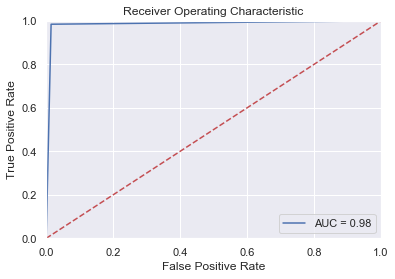

In [16]:
#Naive Bayes Classifier
from sklearn import metrics
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
clf = GaussianNB()
clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
acc=accuracy_score(prediction, labels_test)
print("------------------------------------------")
print("Accuracy = ",acc*100," %")
matrix = confusion_matrix(labels_test, prediction)
print(matrix)
report = classification_report(labels_test, prediction)
print(report)

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(labels_test, prediction)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Feature selection

In [18]:
numeric_names = col_names[numeric_idx].tolist()

In [19]:
#Applying Decision tree to find important features. Higher the score more the important the attribute
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(x, y)

names = numeric_names

print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 10), model.feature_importances_), names), reverse=True))
# display the relative importance of each attribute

Features sorted by their score:
[(0.2244369919, 'count'), (0.1490226392, 'srv_count'), (0.0997760686, 'dst_host_count'), (0.0969591453, 'dst_host_same_src_port_rate'), (0.0934199513, 'same_srv_rate'), (0.0917744244, 'serror_rate'), (0.0780301613, 'dst_host_same_srv_rate'), (0.0415630532, 'dst_host_srv_serror_rate'), (0.0169287864, 'dst_host_rerror_rate'), (0.0143279966, 'dst_host_srv_rerror_rate'), (0.0137503656, 'srv_rerror_rate'), (0.0130991592, 'dst_host_serror_rate'), (0.0120828879, 'hot'), (0.0102659228, 'src_bytes'), (0.0090501162, 'dst_host_srv_diff_host_rate'), (0.0072904696, 'wrong_fragment'), (0.0055583144, 'dst_host_diff_srv_rate'), (0.0054395889, 'srv_serror_rate'), (0.0050748871, 'dst_host_srv_count'), (0.0041579932, 'num_compromised'), (0.00222574, 'srv_diff_host_rate'), (0.0018419889, 'rerror_rate'), (0.0016333788, 'dst_bytes'), (0.001210551, 'diff_srv_rate'), (0.0005884423, 'duration'), (0.0002700907, 'num_failed_logins'), (8.72826e-05, 'num_file_creations'), (5.50833e-

In [20]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

#Load boston housing dataset as an example
names = numeric_names

rf = RandomForestRegressor()
rf.fit(x, y)
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 10), rf.feature_importances_), names), reverse=True))

Features sorted by their score:
[(0.8813508413, 'count'), (0.0296392389, 'src_bytes'), (0.0240819207, 'hot'), (0.0201464193, 'dst_bytes'), (0.0154476891, 'dst_host_count'), (0.0127650348, 'dst_host_srv_diff_host_rate'), (0.0034535037, 'dst_host_same_src_port_rate'), (0.0033584057, 'wrong_fragment'), (0.0022849318, 'srv_serror_rate'), (0.0018417124, 'srv_count'), (0.0014444738, 'dst_host_srv_count'), (0.0010290041, 'dst_host_diff_srv_rate'), (0.0007751845, 'dst_host_serror_rate'), (0.000684813, 'dst_host_rerror_rate'), (0.0004177423, 'dst_host_same_srv_rate'), (0.0003486639, 'duration'), (0.0003323953, 'rerror_rate'), (0.0001961417, 'dst_host_srv_serror_rate'), (7.29778e-05, 'srv_rerror_rate'), (6.15943e-05, 'num_file_creations'), (5.99728e-05, 'same_srv_rate'), (3.48698e-05, 'srv_diff_host_rate'), (2.95551e-05, 'diff_srv_rate'), (2.93662e-05, 'num_shells'), (2.69259e-05, 'dst_host_srv_rerror_rate'), (2.15499e-05, 'num_root'), (1.82717e-05, 'num_failed_logins'), (1.765e-05, 'urgent'), (

In [21]:
x1 = data_df['count']
x2 = data_df['src_bytes']
x3 = data_df['hot']
x4 = data_df['dst_bytes']
x5 = data_df['dst_host_count']
x6 = data_df['dst_host_srv_diff_host_rate']
x7 = data_df['dst_host_same_src_port_rate']
x8 = data_df['wrong_fragment']
x9 = data_df['serror_rate']
x10 = data_df['srv_count']

In [22]:
x = pd.concat ([x1,x2,x3,x4,x5,x6,x7,x8,x9,x10], axis=1)

In [23]:
x.head()
x.transpose()

,0,1,2,3,4,5,6,7,8,9,...,494011,494012,494013,494014,494015,494016,494017,494018,494019,494020
count,-1.521417,-1.521417,-1.521417,-1.530800,-1.530800,-1.530800,-1.554258,-1.535491,-1.521417,-1.521417,...,-1.521417,-1.512033,-1.549566,-1.549566,-1.540183,-1.540183,-1.530800,-1.530800,-1.530800,-1.530800
src_bytes,-0.002879,-0.002820,-0.002824,-0.002840,-0.002842,-0.002842,-0.002847,-0.002901,-0.002849,-0.002847,...,-0.002750,-0.002767,-0.002769,-0.002752,-0.002769,-0.002748,-0.002776,-0.002856,-0.002767,-0.002840
hot,-0.044136,-0.044136,-0.044136,-0.044136,-0.044136,-0.044136,-0.044136,-0.044136,-0.044136,1.234470,...,-0.044136,-0.044136,-0.044136,-0.044136,-0.044136,-0.044136,-0.044136,-0.044136,-0.044136,-0.044136
dst_bytes,0.138664,-0.011578,0.014179,0.014179,0.035214,0.035214,0.032429,0.097411,-0.021717,-0.002498,...,-0.006251,0.030069,-0.018902,-0.006251,0.030069,0.030644,0.042902,0.010032,0.010032,0.011061
dst_host_count,-3.451536,-3.297085,-3.142633,-2.988182,-2.833731,-2.679279,-3.575097,-3.420646,-3.466981,-3.466981,...,-3.034517,-2.880066,-2.725615,-2.571163,-2.416712,-2.262261,-3.497871,-3.343420,-3.188969,-3.497871
dst_host_srv_diff_host_rate,-0.158629,-0.158629,-0.158629,-0.158629,-0.158629,-0.158629,0.790749,0.790749,0.790749,1.028094,...,1.265438,1.028094,1.028094,1.028094,1.028094,1.028094,1.028094,1.028094,1.028094,1.028094
dst_host_same_src_port_rate,-1.022077,-1.146737,-1.188291,-1.188291,-1.209067,-1.209067,0.827048,-1.063631,-1.001301,-1.001301,...,-1.188291,-1.209067,-1.209067,-1.209067,-1.229844,-1.229844,-0.897417,-1.125961,-1.167514,-0.897417
wrong_fragment,-0.047720,-0.047720,-0.047720,-0.047720,-0.047720,-0.047720,-0.047720,-0.047720,-0.047720,-0.047720,...,-0.047720,-0.047720,-0.047720,-0.047720,-0.047720,-0.047720,-0.047720,-0.047720,-0.047720,-0.047720
serror_rate,-0.464090,-0.464090,-0.464090,-0.464090,-0.464090,-0.464090,-0.464090,-0.464090,-0.464090,-0.464090,...,-0.464090,-0.464090,-0.464090,-0.464090,-0.464090,-0.464090,-0.464090,-0.017563,-0.464090,-0.464090
srv_count,-1.156640,-1.156640,-1.156640,-1.164760,-1.164760,-1.164760,-1.180998,-1.168819,-1.156640,-1.156640,...,-1.148521,-1.144461,-1.180998,-1.180998,-1.140401,-1.168819,-1.164760,-1.116043,-1.140401,-1.047028


In [24]:
#Cross validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## Spliting of training dataset into 80% training data and 20% testing data randomly
features_train, features_test, labels_train, labels_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [25]:
#Array for storing classifier Models and their respective scores
models=[]
scores=[]

### Naive Bayes Classifier

------------------------------------------
Accuracy =  97.4060017205607  %
[[19164   189]
 [ 2374 77078]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     19353
           1       1.00      0.97      0.98     79452

    accuracy                           0.97     98805
   macro avg       0.94      0.98      0.96     98805
weighted avg       0.98      0.97      0.97     98805



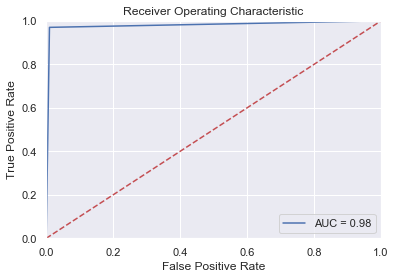

In [26]:
#Naive Bayes Classifier
from sklearn import metrics
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
clf = GaussianNB()
clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
acc=accuracy_score(prediction, labels_test)
print("------------------------------------------")
print("Accuracy = ",acc*100," %")
matrix = confusion_matrix(labels_test, prediction)
print(matrix)
report = classification_report(labels_test, prediction)
print(report)

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(labels_test, prediction)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

models.append("Naive Bayes Classifier")
scores.append(acc*100)

### Decision Tree Classifier

------------------------------------------
Accuracy =  99.86842771114823  %
[[19322    31]
 [   99 79353]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19353
           1       1.00      1.00      1.00     79452

    accuracy                           1.00     98805
   macro avg       1.00      1.00      1.00     98805
weighted avg       1.00      1.00      1.00     98805



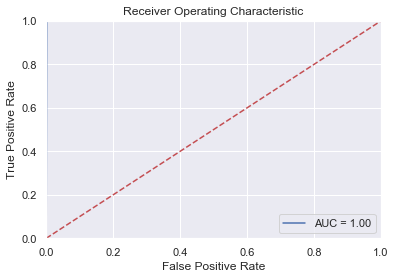

In [27]:
#Decision Tree Classisfier 
from sklearn import tree
clf = tree.DecisionTreeClassifier(splitter = "random", criterion = "entropy", max_depth = 20)
 
clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
## Computing accuracy
from sklearn.metrics import accuracy_score
acc=accuracy_score(prediction, labels_test)
print("------------------------------------------")
print("Accuracy = ",acc*100," %")
matrix = confusion_matrix(labels_test, prediction)
print(matrix)
report = classification_report(labels_test, prediction)
print(report)


from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(labels_test, prediction)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

models.append("Decision tree Classifier")
scores.append(acc*100)

### Random Forest Classifier

------------------------------------------
Accuracy =  99.95647993522596  %
[[19340    13]
 [   30 79422]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19353
           1       1.00      1.00      1.00     79452

    accuracy                           1.00     98805
   macro avg       1.00      1.00      1.00     98805
weighted avg       1.00      1.00      1.00     98805



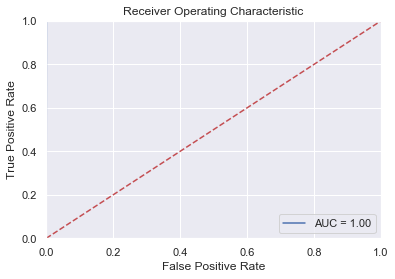

In [28]:
#Random Forest Classifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
acc=accuracy_score(prediction, labels_test)
print("------------------------------------------")
print("Accuracy = ",acc*100," %")
matrix = confusion_matrix(labels_test, prediction)
print(matrix)

report = classification_report(labels_test, prediction)
print(report)


from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(labels_test, prediction)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

models.append("Random Forest Classifier")
scores.append(acc*100)

### K-Nearest Neighbour Classifier

------------------------------------------
Accuracy =  99.8016294721927  %
[[19280    73]
 [  123 79329]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19353
           1       1.00      1.00      1.00     79452

    accuracy                           1.00     98805
   macro avg       1.00      1.00      1.00     98805
weighted avg       1.00      1.00      1.00     98805



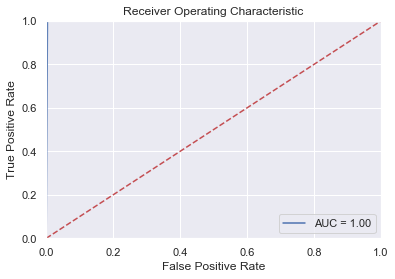

In [29]:
#K-Nearest Neighbour Classifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
# fit a k-nearest neighbor model to the data
clf = KNeighborsClassifier()
clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
acc=accuracy_score(prediction, labels_test)
print("------------------------------------------")
print("Accuracy = ",acc*100," %")
matrix = confusion_matrix(labels_test, prediction)
print(matrix)

report = classification_report(labels_test, prediction)
print(report)


from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(labels_test, prediction)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

models.append("K-Nearest neighbour Classifier")
scores.append(acc*100)

### Logistic Regression Classifier

------------------------------------------
Accuracy =  98.8927685845858  %
[[19210   143]
 [  951 78501]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     19353
           1       1.00      0.99      0.99     79452

    accuracy                           0.99     98805
   macro avg       0.98      0.99      0.98     98805
weighted avg       0.99      0.99      0.99     98805



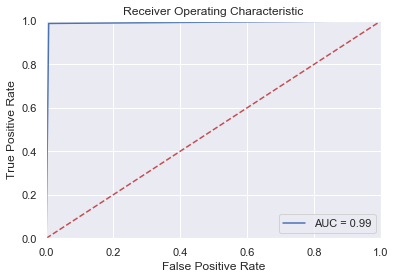

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import stochastic_gradient


clf = LogisticRegression()  
clf.fit(features_train, labels_train)  
prediction = clf.predict(features_test)
acc=accuracy_score(prediction, labels_test)
print("------------------------------------------")
print("Accuracy = ",acc*100," %")
matrix = confusion_matrix(labels_test, prediction)
print(matrix)

report = classification_report(labels_test, prediction)
print(report)


from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(labels_test, prediction)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

models.append("Logistic Regression Classifier")
scores.append(acc*100)

### Linear SVM Classifier

------------------------------------------
Accuracy =  98.86240574869693  %
[[19254    99]
 [ 1025 78427]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     19353
           1       1.00      0.99      0.99     79452

    accuracy                           0.99     98805
   macro avg       0.97      0.99      0.98     98805
weighted avg       0.99      0.99      0.99     98805



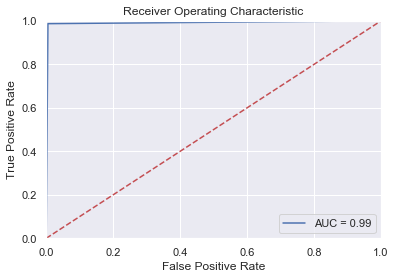

In [31]:
from sklearn.svm import LinearSVC   


clf = LinearSVC() 
clf.fit(features_train, labels_train)  
prediction = clf.predict(features_test)
acc=accuracy_score(prediction, labels_test)
print("------------------------------------------")
print("Accuracy = ",acc*100," %")
matrix = confusion_matrix(labels_test, prediction)
print(matrix)

report = classification_report(labels_test, prediction)
print(report)


from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(labels_test, prediction)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

models.append("LinearSVC")
scores.append(acc*100)

### Comparing Table

In [32]:
#Making a dataframe that consists of models and their respective scores
dat = pd.DataFrame(index=[1,2,3,4,5,6])
dat["Model"] = models
dat["Score"] = scores
dat.set_index("Model")

,Score
Model,
Naive Bayes Classifier,97.406002
Decision tree Classifier,99.868428
Random Forest Classifier,99.956480
K-Nearest neighbour Classifier,99.801629
Logistic Regression Classifier,98.892769
LinearSVC,98.862406


## Conclusion
In this example, the performance of the linear model does not perform as well as the tree model.